In this notebook, i test the models with test dataset.

The models have the same architecture, but they are trained with different epochs except the last one which instead of having a 80-20 validation training I introduced the test set and has a 70-15-15 (showed in the neural network notebook)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

import time

from tensorflow import keras
from tensorflow.keras import layers

import sklearn
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
import itertools

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images_path = '/content/drive/MyDrive/TESI/Spectogram_images/all_test_faults_images'

learning_path = '/content/drive/MyDrive/TESI/keras_file'

drive_test_path = '/content/drive/MyDrive/TESI/Label_test'

Notebook is runned by T4 GPU

# Load **test** set

In [ ]:
image_size = (180, 180)
batch_size = 1

start_time = time.time()

all_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    labels="inferred",
    label_mode='int',   # Only for have simple label class for confusion matrix

    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

end_time = time.time()
execution_time = end_time - start_time

print()
print(f"Execution time: {execution_time:.3f} seconds")

Found 75999 files belonging to 14 classes.

Execution time: 136.649 seconds


In [ ]:
class_name_ordered = all_ds.class_names

print(class_name_ordered)

['B007', 'B014', 'B021', 'IR007', 'IR014', 'IR021', 'Normal', 'OR007-12', 'OR007-3', 'OR007-6', 'OR014-6', 'OR021-12', 'OR021-3', 'OR021-6']


In [ ]:
# Divide the dataset into 3 parts.
part_size = (len(all_ds) // 3)

part_1 = all_ds.take(part_size)
part_2 = all_ds.skip(part_size).take(part_size)
part_3 = all_ds.skip(part_size * 2).take(-1)

print(f'All images: {len(all_ds)} -> divided into: part 1: {len(part_1)}, part 2: {len(part_2)}, part 3: {len(part_3)}')

if len(all_ds) != (len(part_1) + len(part_2) + len(part_3)):
  print('Check the rest of division')
else:
  print('Divided without rest')

All images: 75999 -> divided into: part 1: 25333, part 2: 25333, part 3: 25333
Divided without rest


# Get labels of test set

In [ ]:
name_file = 'Labels.npy'

labels_file_path = os.path.join(drive_test_path, name_file)

print(labels_file_path)

/content/drive/MyDrive/TESI/Label_test/Labels.npy


In [ ]:
# Get label of images from all part of dataset

if not os.path.exists(labels_file_path):
  start_time = time.time()

  numpy_labels_list = []

  p=0
  for part in (part_1, part_2, part_3):
    start_partial_time = time.time()

    part_unbatch = part.unbatch()

    labels = part.as_numpy_iterator()

    for label in labels:
        numpy_labels_list.append(label[-1])

    # Save partial
    np.save(os.path.join(drive_test_path, 'partial'+str(p)), numpy_labels_list)
    p=p+1
    end_partial_time = time.time()
    execution_time = (end_partial_time - start_partial_time)//60
    print(f"Execution partial time: {execution_time} minutes")

  # Save total
  np.save(labels_file_path, numpy_labels_list)
  print('Labels file saved in local')

  end_time = time.time()
  execution_time = (end_time - start_time)//60
  print(f"Execution time: {execution_time} minutes")
else:
  print('Labels file find')
  numpy_labels_list = np.load(labels_file_path)

Labels file find


Get labels from Tensorflow test dataset:
- Processing full Tensorflow dataset
  - 56 minutes for 15200 images (20% database)
  - Run out all RAM memmory for greater percentuage of dataset

- Dividing in 3 part the Tensorflow dataset and processate seperately, all 75999 images:
 - Execution partial time: 44.0 minutes
 - Execution time: 133.0 minutes
 - Using RAM of sistem 6.8 / 12.7 GB

In [ ]:
# Labels value is stored such as numpy array of numpy array, here it convert it in a simple list

numpy_labels_list = numpy_labels_list.tolist()
labels_list = []

for i in numpy_labels_list:
  labels_list.append(i[0] )

print(type(labels_list),type(labels_list[0]))
print(labels_list[:5])

print('Total labels: ',len(labels_list))

<class 'list'> <class 'int'>
[0, 0, 0, 0, 0]
Total labels:  75999


# Re-load all model 80-20 and predict test dataset

In [ ]:
keras_models = ['20230924-131558 first_model_2.keras', '20230924-195804_best_model_3.keras', '20230924-195804_last_model.keras']
accuracy_results = {}

Model list

1) First model trained for 25 Epochs: 20230924-131558 first_model_2.keras

2) Second model trained for 33 Epochs with ModelCheckpoint, best val_loss: 20230924-195804_best_model_3.keras

3) Third model trained for 43 Epochs: 20230924-195804_last_model.keras

In [ ]:
  # Look at confusion matrix

  def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
      """
      This function prints and plots the confusion matrix.
      Normalization can be applied by setting `normalize=True`.
      """
      plt.imshow(cm, interpolation='nearest', cmap=cmap)
      plt.title(title)
      plt.colorbar()
      tick_marks = np.arange(len(classes))
      plt.xticks(tick_marks, classes, rotation=45)
      plt.yticks(tick_marks, classes)

      if normalize:
          cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

      thresh = cm.max() / 2.
      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, cm[i, j],
                  horizontalalignment="center", fontsize=6,
                  color="white" if cm[i, j] > thresh else "black")

      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()



--------------- MODEL: 20230924-131558 first_model_2.keras ---------------

75999/75999 [==============================] - 357s 5ms/step
Execution of prediction time: 6.0 minutes


Accuracy balanced score:  0.9046468987864077




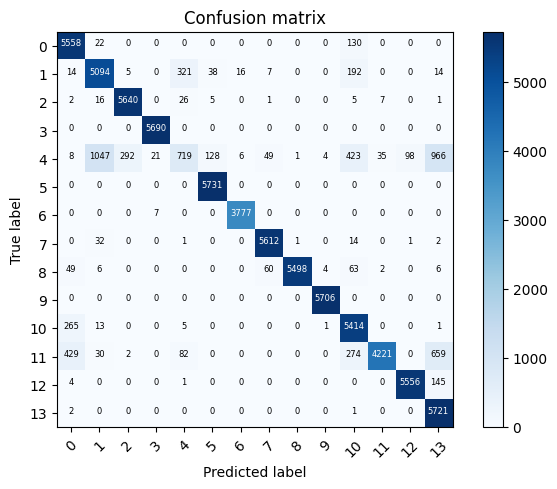



--------------- MODEL: 20230924-195804_best_model_3.keras ---------------

75999/75999 [==============================] - 367s 5ms/step
Execution of prediction time: 6.0 minutes


Accuracy balanced score:  0.8971257203455686




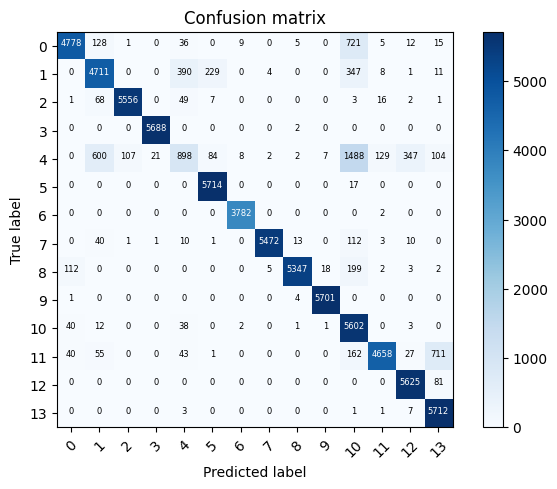



--------------- MODEL: 20230924-195804_last_model.keras ---------------

75999/75999 [==============================] - 569s 7ms/step
Execution of prediction time: 10.0 minutes


Accuracy balanced score:  0.8946926916891023




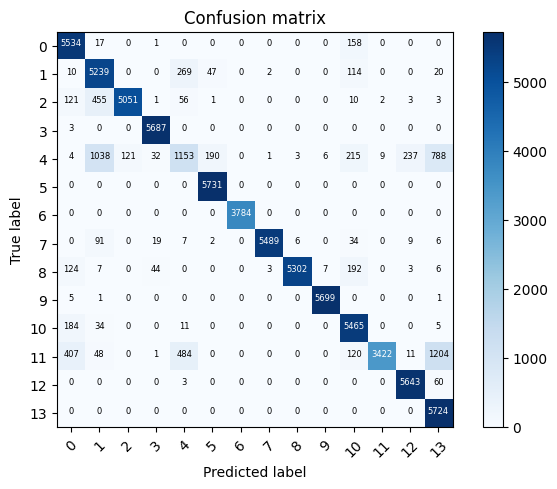

In [ ]:
x=0
for keras_model in keras_models:
  start_time = time.time()

  print(f'\n\n--------------- MODEL: {keras_model} ---------------\n')

  load_model_path = os.path.join (learning_path, keras_model)

  model = keras.models.load_model(load_model_path)

  predict = model.predict(all_ds)

  # Save partial
  np.save(os.path.join(drive_test_path, 'predict'+str(x)), predict)
  x=x+1

  # Predict the values from the validation dataset
  Y_pred = predict
  # Convert predictions classes to one hot vectors
  Y_pred_classes = np.argmax(Y_pred,axis = 1)
  # Convert validation observations to one hot vectors
  Y_true = labels_list
  # compute the confusion matrix
  confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

  # Print data
  end_time = time.time()
  execution_time = (end_time - start_time)//60
  print(f"Execution of prediction time: {execution_time} minutes")
  print('\n')

  accuracy = sklearn.metrics.balanced_accuracy_score(Y_true, Y_pred_classes)
  print('Accuracy balanced score: ', accuracy)
  print('\n')

  plot_confusion_matrix(confusion_mtx, classes = range(14))

  accuracy_results[keras_model] = accuracy

The first prediction takes 50 minutes because it do a images rescaling, then the code takes 6 minutes to run for each prediction.


## Results

In [ ]:
# Resume of predict

for keras_model in keras_models:
  print(f'Model: {keras_model} has {accuracy_results[keras_model]}')

Model: 20230924-131558 first_model_2.keras has 0.9046468987864077
Model: 20230924-195804_best_model_3.keras has 0.8971257203455686
Model: 20230924-195804_last_model.keras has 0.8946926916891023


# Re-load last model 70-15-15 and predict test dataset

In [ ]:
keras_model = '20231011-151753_model_4_last_epoch.keras'
load_model_path = os.path.join (learning_path, keras_model)
checkpoint = os.path.join(learning_path, '20231011-151753_model_4_best_epoch','cp-0011.ckpt')
# Do it manually because it raise a error with Google Drive



--------------- MODEL: 20231011-151753_model_4_last_epoch.keras ---------------

75999/75999 [==============================] - 352s 5ms/step
Execution of prediction time: 6.0 minutes


Accuracy balanced score:  0.896882179891797




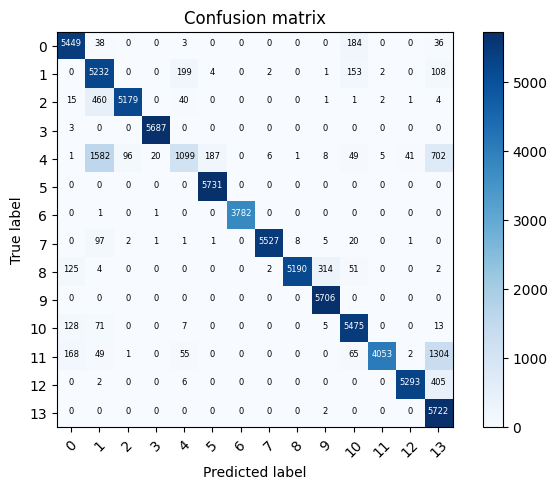

In [ ]:
start_time = time.time()

print(f'\n\n--------------- MODEL: {keras_model} ---------------\n')

model = keras.models.load_model(load_model_path)

#load the best weigh

model.load_weights(checkpoint)

predict = model.predict(all_ds)

# Save partial
np.save(os.path.join(drive_test_path, 'predict_3'), predict)

# Predict the values from the validation dataset
Y_pred = predict
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = labels_list
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Print data
end_time = time.time()
execution_time = (end_time - start_time)//60
print(f"Execution of prediction time: {execution_time} minutes")
print('\n')

accuracy = sklearn.metrics.balanced_accuracy_score(Y_true, Y_pred_classes)
print('Accuracy balanced score: ', accuracy)
print('\n')

plot_confusion_matrix(confusion_mtx, classes = range(14))

accuracy_results[keras_model] = accuracy

Legenda: ['B007', 'B014', 'B021', 'IR007', 'IR014', 'IR021', 'Normal', 'OR007-12', 'OR007-3', 'OR007-6', 'OR014-6', 'OR021-12', 'OR021-3', 'OR021-6']


In [ ]:
B007 = 5449/(5449+38+3+184+36)
B014 = 5232/(5232+199+4+2+1+153+2+108)
B021 = 5179/(15+460+5179+40+1+1+2+1+4)
IR007 = 5687/(3+5687)
IR014 = 1099/(1582+96+20+1099+187+6+1+8+49+5+41+702)
IR021 = 5731/5731
Normal = 3782/(1+1+3782)
OR007_12 = 5527/(97+2+1+1+1+5527+8+5+20+1)
OR007_3 = 5190/(125+4+2+5190+314+51+2)
OR007_6 = 5706/5706
OR014_6 = 5475/(128+71+7+5+5475+13)
OR021_12 = 4053/(168+49+1+55+65+4053+2+1304)
OR021_3 = 5293/(2+6+5293+405)
OR021_6 = 5722/5722

legend = ['B007', 'B014', 'B021', 'IR007', 'IR014', 'IR021', 'Normal', 'OR007-12', 'OR007-3', 'OR007-6', 'OR014-6', 'OR021-12', 'OR021-3', 'OR021-6']
precision_label = [B007, B014, B021, IR007, IR014, IR021, Normal, OR007_12, OR007_3, OR007_6, OR014_6, OR021_12, OR021_3, OR021_6]

accuracy_ball = (5449+38+5232+15+460+5179) / ((5449+38+3+184+36)+(5232+199+4+2+1+153+2+108)+(15+460+5179+40+1+1+2+1+4))
accuracy_inner_race = (5687+20+1099+187+5731) / ((3+5687)+(1582+96+20+1099+187+6+1+8+49+5+41+702)+(5731))
accuracy_inner_race_minus4  = (5687+5731) / ((3+5687)+(5731))
accuracy_outer_race = (5527+8+5+20+1+2+5190+314+51+2+5706+5+5475+13+65+4053+2+1304+5293+405+5722) / ((97+2+1+1+1+5527+8+5+20+1)+(125+4+2+5190+314+51+2)+(5706)+(128+71+7+5+5475+13)+(168+49+1+55+65+4053+2+1304)+(2+6+5293+405)+(5722))

n = 0
for i in precision_label:
  print(f'Label {n} is the {legend[n]} fault and has an accuracy of {i:.4f}')
  n +=1
print(f'\nAccuracy of ball faults = {accuracy_ball:.2f} \n| Accuracy of inner race faults = {accuracy_inner_race:.2f}\n| Accuracy of inner race faults -> minus label 4 = {accuracy_inner_race_minus4:.2f}\nAccuracy of outer race faults = {accuracy_outer_race:.2f}\nprecision_normal: {Normal:.2f}')

Label 0 is the B007 fault and has an accuracy of 0.9543
Label 1 is the B014 fault and has an accuracy of 0.9177
Label 2 is the B021 fault and has an accuracy of 0.9081
Label 3 is the IR007 fault and has an accuracy of 0.9995
Label 4 is the IR014 fault and has an accuracy of 0.2895
Label 5 is the IR021 fault and has an accuracy of 1.0000
Label 6 is the Normal fault and has an accuracy of 0.9995
Label 7 is the OR007-12 fault and has an accuracy of 0.9760
Label 8 is the OR007-3 fault and has an accuracy of 0.9124
Label 9 is the OR007-6 fault and has an accuracy of 1.0000
Label 10 is the OR014-6 fault and has an accuracy of 0.9607
Label 11 is the OR021-12 fault and has an accuracy of 0.7114
Label 12 is the OR021-3 fault and has an accuracy of 0.9276
Label 13 is the OR021-6 fault and has an accuracy of 1.0000

Accuracy of ball faults = 0.96 
| Accuracy of inner race faults = 0.84
| Accuracy of inner race faults -> minus label 4 = 1.00
Accuracy of outer race faults = 0.98
precision_normal: 1